## Leaf Dieasese Classification

## imports

In [2]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import json


## PART 1: EXPLORATORY DATA ANALYSIS

### Dataset Overview and Class Analysis

In [3]:
DATA_DIR = './Data/' 
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
LABEL_MAP_PATH = os.path.join(DATA_DIR, 'label_num_to_disease_map.json')

# Read the training CSV file
df = pd.read_csv(TRAIN_CSV)
print(f"Total number of images: {len(df)}")
print(f"\nFirst few rows:")
print(df.head())

# Load label mapping
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)
print(f"\nLabel mapping:")
for key, value in label_map.items():
    print(f"  {key}: {value}")

# Count images per class and show as dataframe
class_counts = df['label'].value_counts().sort_index().reset_index()
class_counts.columns = ['label', 'num_images']
class_counts['disease_name'] = class_counts['label'].astype(str).map(label_map)
print(f"\nClass distribution:")
print(class_counts)

Total number of images: 21397

First few rows:
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Label mapping:
  0: Cassava Bacterial Blight (CBB)
  1: Cassava Brown Streak Disease (CBSD)
  2: Cassava Green Mottle (CGM)
  3: Cassava Mosaic Disease (CMD)
  4: Healthy

Class distribution:
   label  num_images                         disease_name
0      0        1087       Cassava Bacterial Blight (CBB)
1      1        2189  Cassava Brown Streak Disease (CBSD)
2      2        2386           Cassava Green Mottle (CGM)
3      3       13158         Cassava Mosaic Disease (CMD)
4      4        2577                              Healthy


## Visualize sample images from each class

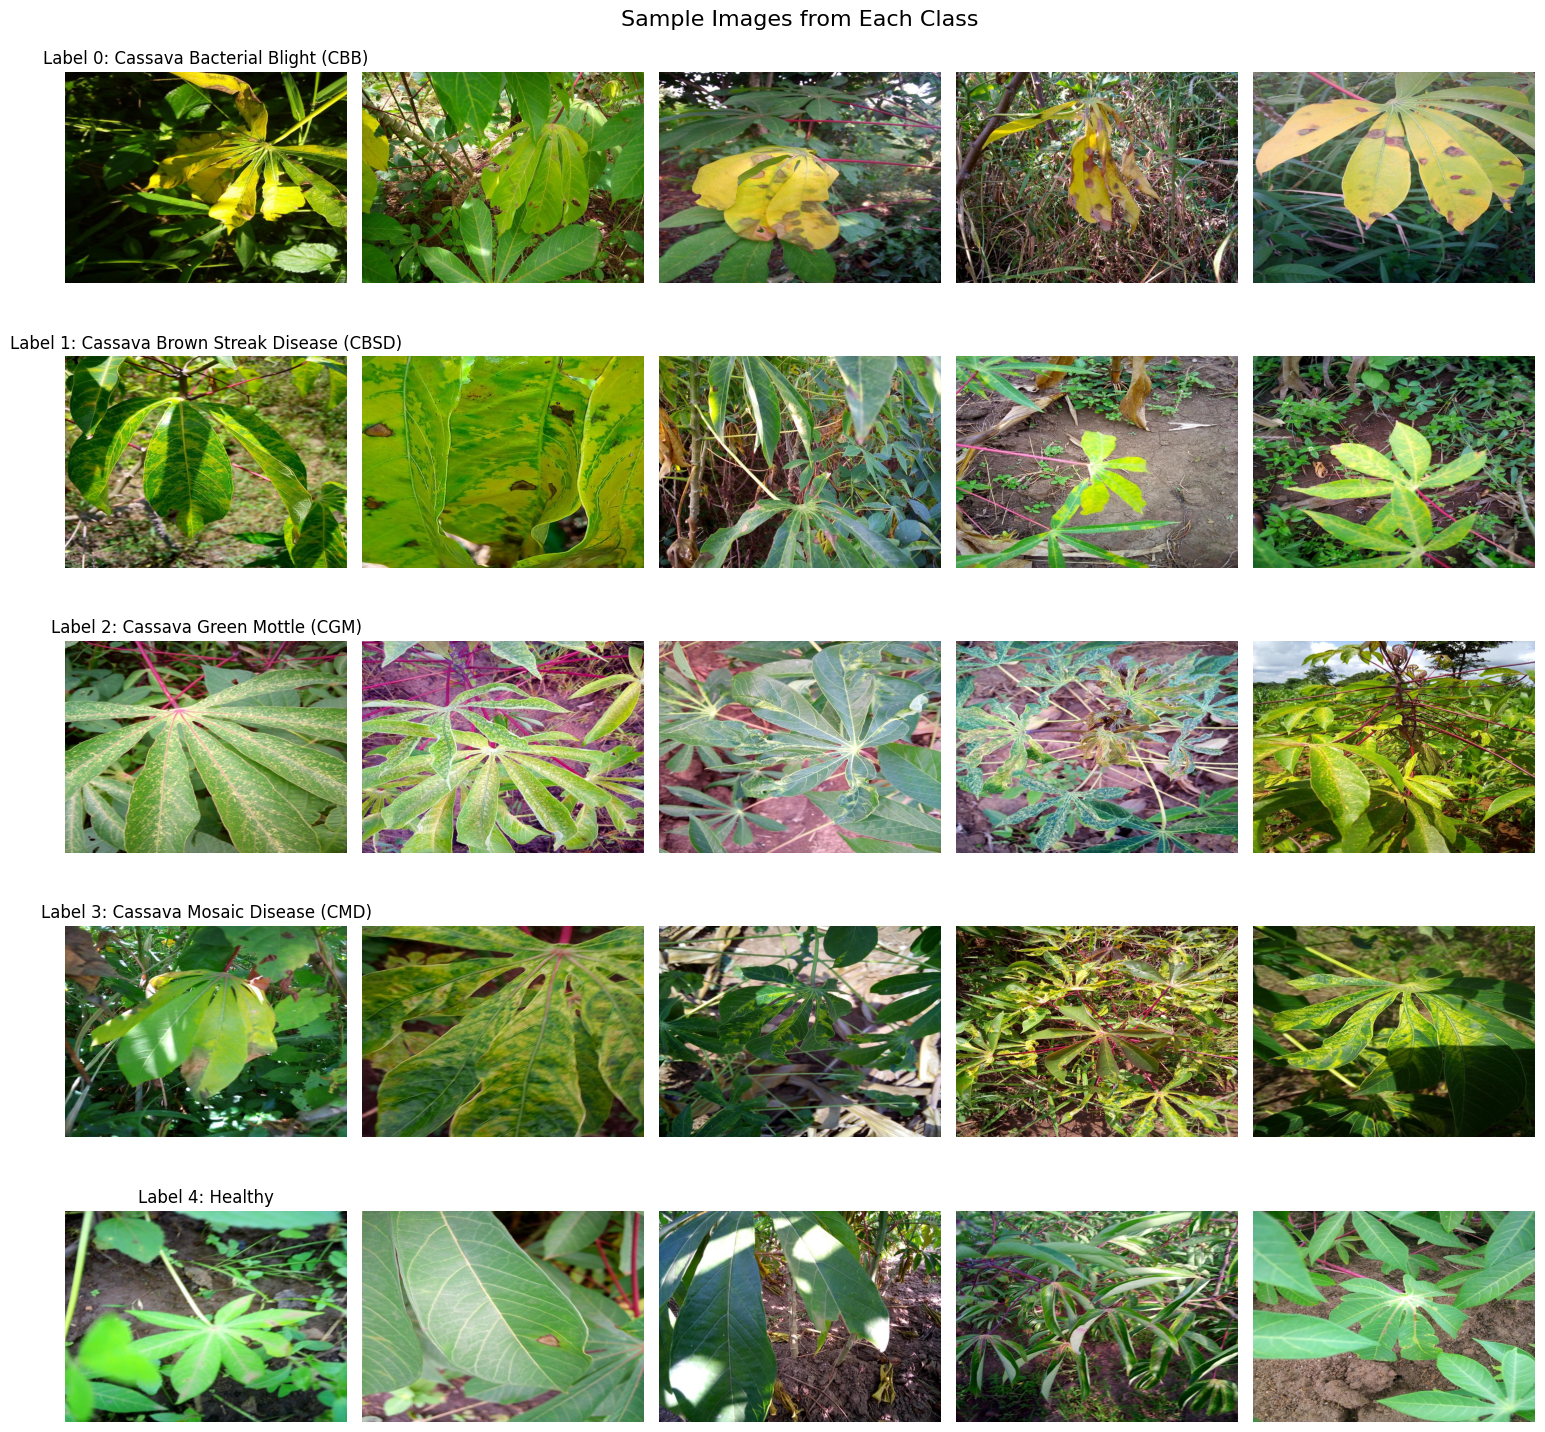

In [ ]:

fig, axes = plt.subplots(len(label_map), 5, figsize=(15, 3*len(label_map)))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for label_idx, (label_num, disease_name) in enumerate(sorted(label_map.items(), key=lambda x: int(x[0]))):
    label = int(label_num)
    # Get 5 random samples from this class
    class_samples = df[df['label'] == label]['image_id'].sample(min(5, len(df[df['label'] == label])))
    
    for img_idx, image_id in enumerate(class_samples):
        img_path = os.path.join(TRAIN_IMAGES_DIR, image_id)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[label_idx, img_idx].imshow(img)
            axes[label_idx, img_idx].set_title(f'Label {label}: {disease_name}' if img_idx == 0 else '')
            axes[label_idx, img_idx].axis('off')
        else:
            axes[label_idx, img_idx].text(0.5, 0.5, 'Image\nnot found', 
                                         ha='center', va='center', transform=axes[label_idx, img_idx].transAxes)
            axes[label_idx, img_idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
sample_images = []
sample_labels = []

for _, row in df.sample(min(100, len(df))).iterrows():
    img_path = os.path.join(TRAIN_IMAGES_DIR, row['image_id'])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        sample_images.append(img.size)
        sample_labels.append(row['label'])

if sample_images:
    widths, heights = zip(*sample_images)
    print(f"Image dimensions statistics (from {len(sample_images)} samples):")
    print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
    print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
    print(f"  Common sizes: {Counter(sample_images).most_common(5)}")


Image dimensions statistics (from 100 samples):
  Width:  min=800, max=800, mean=800.0
  Height: min=600, max=600, mean=600.0
  Common sizes: [((800, 600), 100)]
